### Polynomial Chaos Expansion example: 2D Helmholtz eigenvalues (2 random inputs, vector-valued output)

Authors: Dimitris Loukrezis, Katiana Kontolati \
Date: May 7, 2021

In this example, PCE is used to generate a surrogate model for a given set of 2D data for a numerical model with multi-dimensional outputs.

Import necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from UQpy.distributions import Normal, JointIndependent
from UQpy.surrogates import *

/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
The selected optimizer method does not support bounds and thus will be ignored.
The selected optimizer method does not support bounds and thus

The analytical function below describes the eigenvalues of the 2D Helmholtz equation on a square.

In [2]:
def analytical_eigenvalues_2d(Ne, lx, ly):
    """
    Computes the first Ne eigenvalues of a rectangular waveguide with 
    dimensions lx, ly

    Parameters
    ----------
    Ne : integer
         number of eigenvalues.
    lx : float
         length in x direction.
    ly : float
         length in y direction.

    Returns
    -------
    ev : numpy 1d array
         the Ne eigenvalues
    """
    ev = [(m*np.pi/lx)**2 + (n*np.pi/ly)**2 for m in range(1, Ne+1) 
                                            for n in range(1, Ne+1)]                                                 
    ev = np.array(ev)
    
    return ev[:Ne]


Create a distribution object.

In [3]:
pdf_lx = Normal(loc=2, scale=0.02)   
pdf_ly = Normal(loc=1, scale=0.01)
margs = [pdf_lx, pdf_ly]
joint = JointIndependent(marginals=margs)

Define the number of input dimensions and choose the number of output dimensions (number of eigenvalues).

In [4]:
dim_in = 2
dim_out = 10 

Construct PCE models by varying the maximum degree of polynomials (and therefore the number of polynomial basis) and compute the validation error for all resulting models.

In [5]:
errors = []
# construct PCE surrogate models
for max_degree in range(1,6):
    print('Total degree: ', max_degree)
    polynomial_basis = PolynomialBasis.create_total_degree_basis(joint, max_degree)
    
    print('Size of basis:', polynomial_basis.polynomials_number)
    # training data
    sampling_coeff = 5
    print('Sampling coefficient: ', sampling_coeff)
    np.random.seed(42)
    n_samples = math.ceil(sampling_coeff*polynomial_basis.polynomials_number)
    print('Training data: ', n_samples)
    xx = joint.rvs(n_samples)
    yy = np.array([analytical_eigenvalues_2d(dim_out, x[0], x[1]) for x in xx])
    
    # fit model
    least_squares = LeastSquareRegression()
    pce_metamodel = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)
    pce_metamodel.fit(xx, yy)
    
    # coefficients
    #print('PCE coefficients: ', pce.C)
    
    # validation errors
    np.random.seed(999)
    n_samples = 1000
    x_val = joint.rvs(n_samples)
    y_val = np.array([analytical_eigenvalues_2d(dim_out, x[0], x[1]) for x in x_val])
    y_val_pce = pce_metamodel.predict(x_val)
    errors.append(np.linalg.norm((y_val - y_val_pce)/y_val, ord=1, axis=0))
    print('Relative absolute errors: ', errors[-1])
    print('')

Total degree:  1
Size of basis: 3
Sampling coefficient:  5
Training data:  15
Relative absolute errors:  [0.25787331 0.28364754 0.29201537 0.29532324 0.29691008 0.29778109
 0.29831043 0.2986553  0.29889252 0.29906269]

Total degree:  2
Size of basis: 6
Sampling coefficient:  5
Training data:  30
Relative absolute errors:  [0.00475743 0.0051856  0.00531297 0.00536752 0.00539496 0.00541011
 0.00541937 0.00542546 0.00542968 0.00543271]

Total degree:  3
Size of basis: 10
Sampling coefficient:  5
Training data:  50
Relative absolute errors:  [0.00012562 0.00014033 0.00014521 0.00014706 0.00014794 0.00014842
 0.00014872 0.00014891 0.00014904 0.00014913]

Total degree:  4
Size of basis: 15
Sampling coefficient:  5
Training data:  75
Relative absolute errors:  [1.88728323e-06 1.90860544e-06 1.92961221e-06 1.94463742e-06
 1.95400952e-06 1.95956403e-06 1.96292944e-06 1.96512046e-06
 1.96687111e-06 1.96840792e-06]

Total degree:  5
Size of basis: 21
Sampling coefficient:  5
Training data:  105
R

Plot errors.

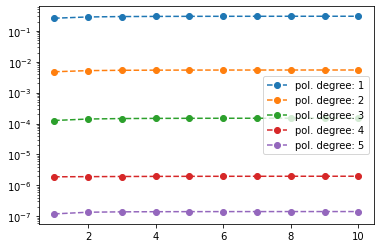

In [6]:
errors = np.array(errors)
plt.figure(1)
for i in range(np.shape(errors)[0]):
    plt.semilogy(np.linspace(1, dim_out, dim_out), errors[i], '--o', label='pol. degree: {}'.format(i+1))
plt.legend()
plt.show()

Moment estimation (directly estimated from the last PCE metamodel).

In [7]:
print('Mean PCE estimate:', pce_metamodel.get_moments()[0])
print('')
print('Variance PCE estimate:', pce_metamodel.get_moments()[1])

Mean PCE estimate: [ 12.3407  41.9584  91.3212 160.4292 249.2823 357.8805 486.2239 634.3124
 802.146  989.7248]

Variance PCE estimate: [4.150000e-02 6.269000e-01 3.163700e+00 9.993600e+00 2.439500e+01
 5.058280e+01 9.370870e+01 1.598612e+02 2.560653e+02 3.902826e+02]
